In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import AutoEncoder_gnnrnn, AutoEncoder_rnn
from data import prepare_data_vocab, live_feat, batch_gnn_for_gpu, split_pp_into_sublists, split_train_test, count_occurrences
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler

[['store', 'double', 'TMP_VAR(INFUNCTION_VAR)', 'TMP_VAR', ';', 'load', 'TMP_VAR', 'double', 'TMP_VAR(INFUNCTION_VAR)', ';', 'assignment', 'TMP_POINTER_MEMBER', 'TMP_VAR', ';', 'assignment', 'TMP_VAR', 'TMP_POINTER_MEMBER', ';', 'math_op', 'TMP_VAR', 'TMP_NUMBER', '/', 'TMP_VAR', ';', 'function_call', 'INFUNCTION_VAR', 'TMP_FUNCTION_ARG_1', 'TMP_FUNCTION_ARG_2', ';', 'function_call', 'INFUNCTION_VAR', 'TMP_FUNCTION_ARG_1', 'TMP_FUNCTION_ARG_2', 'TMP_FUNCTION_ARG_3', 'TMP_FUNCTION_ARG_4', ';', 'math_op', 'TMP_VAR', 'TMP_VAR', '+', 'TMP_NUMBER', ';', 'assignment', 'INFUNCTION_VAR', 'TMP_VAR', ';', 'phi', ';']]


In [3]:
word_to_idx, idx_to_word, data, data_emb = prepare_data_vocab("data", func=live_feat, function_num=0)

## GNN LSTM

In [ ]:
#return grad_input.min(), grad_input.min(), grad_input.min()

In [47]:
def register_hooks(model):
    hooks = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            hooks.append(layer.register_full_backward_hook(get_gradient))
    return hooks

def get_gradient(module, grad_input, grad_output):
    #print('Gradient Input:', grad_input)  # Gradients with respect to inputs
    #return grad_input
    #print('Gradient Output:', grad_output)  # Gradients with respect to outputs
    global total_gradients, total_parameters, dict_grad
    for name, param in module.named_parameters():
        if param.grad is not None:
            grad = param.grad
            dict_grad[name] = total_gradients
            total_gradients += grad.abs().sum().item()
            total_parameters += grad.numel()


In [41]:
bidir          = True
dir            = 2 if bidir else 1 
batch_size     = 64
num_layers_enc = 2
hidden_dim_enc = 64
num_layers_dec = 2
hidden_dim_dec = 32
emb_dim        = 64
N_max          = len(word_to_idx)+1
layer_dims_gnn = [32, 16]

dataset = split_pp_into_sublists(data_emb, batch_size)
(train, test) = split_train_test(dataset)

ae = AutoEncoder_gnnrnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            layer_dims_gnn = layer_dims_gnn,
            emb_dim        = emb_dim,
            N_max          = N_max)

if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

#device = torch.device("cpu")
ae.to(device)


train_gpu = batch_gnn_for_gpu(train, device, len(word_to_idx))
test_gpu = batch_gnn_for_gpu(test, device, len(word_to_idx))
weight = count_occurrences(train, word_to_idx, device)


criterion = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)

hooks = register_hooks(ae)
# Before the training loop
total_gradients = 0.0
total_parameters = 0

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

#optimizer = optim.SGD(ae.parameters(), lr=0.1, momentum=0.9)
#scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

In [42]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
grad_avg = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="mix", ratio=0.5, ratio_mix=0.5)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    for hook in hooks:
        hook.remove()  # Remove previous hooks
    hooks = register_hooks(ae)
    grad_avg.append(total_gradients/total_parameters)
    #print(hooks[0])
    # Optionally, you can print the learning rate to monitor its changes
        #print("Learning Rate:", optimizer.param_groups[0]['lr'])
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

0.0003645151784952697
For 54116 Tokens List in Train set: Epoch 1/100, Average Loss: 2.20049, Acuuracy: 11.07483
For 13607 Tokens List in Test set: Epoch 1/100, Average Loss: 2.59770, Acuuracy: 7.44449
-----------------------------------------------------------------------------------
0.0003063206550115309
0.0002826351602610464 in Train set: Epoch 2/100, Average Loss: 1.29945, Acuuracy: 27.26814
0.00026632757143269165in Train set: Epoch 3/100, Average Loss: 1.10295, Acuuracy: 33.18889
0.00025184079546105355in Train set: Epoch 4/100, Average Loss: 1.04587, Acuuracy: 35.13862
0.0002409991146532671 in Train set: Epoch 5/100, Average Loss: 0.89751, Acuuracy: 40.75826
For 54116 Tokens List in Train set: Epoch 6/100, Average Loss: 0.84801, Acuuracy: 42.82681
For 13607 Tokens List in Test set: Epoch 6/100, Average Loss: 2.25915, Acuuracy: 10.44395
-----------------------------------------------------------------------------------
0.00023283904478343763
0.00022459329157708144in Train set: Epoc

KeyboardInterrupt: 

In [ ]:
for hook in hooks:
    hook.remove()

In [46]:
for name, param in ae.named_parameters():
    print(name)
    print(param)
    print("-------------------------------")

enc.weight_ih_l0
Parameter containing:
tensor([[-0.7218,  0.3673,  0.3925,  ..., -0.1274, -0.1911, -0.0575],
        [-0.5486, -0.2140,  0.3919,  ..., -0.0996, -0.2331,  0.3569],
        [ 0.2631,  0.4226,  0.2895,  ..., -0.8137,  0.4365, -0.6244],
        ...,
        [ 0.7515,  0.2327, -0.2643,  ..., -0.1543, -0.0575, -0.4267],
        [ 0.1540, -0.1479, -0.2918,  ...,  0.0502, -0.7872,  0.3232],
        [ 0.7401,  0.2447, -1.1955,  ...,  0.0285,  0.2472, -1.1198]],
       device='cuda:0', requires_grad=True)
-------------------------------
enc.weight_hh_l0
Parameter containing:
tensor([[-0.1510, -0.7207, -0.2121,  ..., -0.4485, -0.2166,  0.1380],
        [ 0.1814,  0.1122, -0.0619,  ...,  0.6065,  0.9286, -0.9765],
        [ 0.0046, -0.2300, -0.2010,  ..., -0.1728,  0.0884, -0.3822],
        ...,
        [-0.5066,  0.6278,  0.0760,  ...,  0.3865,  0.5576,  0.1224],
        [ 0.0628,  0.2472,  0.3245,  ..., -0.3430,  0.3996,  0.4059],
        [-0.1887,  0.2664,  0.1258,  ..., -0.2920

## Performance Visualization

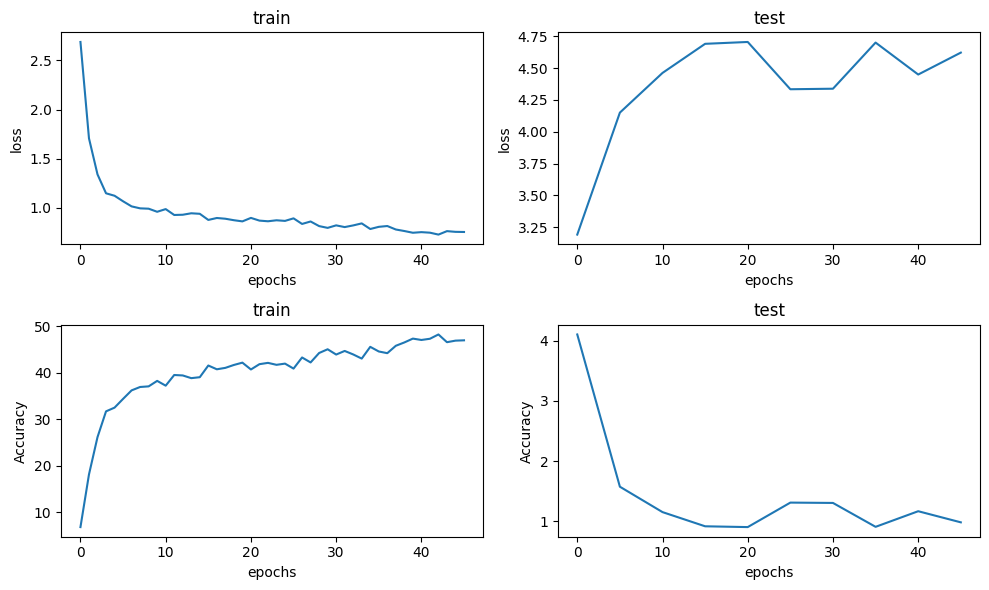

In [231]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,6)) 
x = [i*5 for i in range(len(accu_test))]
axs[0,0].plot(loss_train)
axs[0,0].set_ylabel("loss")
axs[0,0].set_xlabel("epochs")
axs[0,0].set_title("train")
axs[1,0].plot(accu_train)
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("epochs")
axs[1,0].set_title("train")
axs[0,1].plot(x, loss_test)
axs[0,1].set_ylabel("loss")
axs[0,1].set_xlabel("epochs")
axs[0,1].set_title("test")
axs[1,1].plot(x, accu_test)
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("epochs")
axs[1,1].set_title("test")
plt.tight_layout()
plt.savefig('AE_result.png')

In [49]:
d = {'a': 1, 'b':2}
for key, val in d.items():
    print(key, val)

a 1
b 2


In [62]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="mix", ratio=1, ratio_mix=1)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="teaching", ratio=1, ratio_mix=1)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break

pred:	8	28	8	25	8	8	8	8	8	8	8	28	8	25	25	8	8	8	28	28	8	8	8	8	28	8	25	25	8	8	8	28	8	25	25	8	8	28	8	8	8	8	28	8	8	8	8	25	25	8	8	25	25	8	8	8	28	8	8	8	8	8	8	28	8	28	8	25	8	25	25	8	8	8	8	8	8	8	8	25	25	8	8	8	28	8	8	25	25	25	25	8	8	8	8	8	8	8	8	25	25	8	8	8	28	8	8	25	25	25	25	25	8	25	25	25	8	25	8	8	8	8	8	8	8	8	25	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	25	8	25	25	25	25	8	8	8	28	8	8	25	8	8	8	8	8	28	8	25	8	8	8	28	8	25	8	8	8	28	8	25	25	8	8	8	28	8	8	25	25	25	25	25	8	25	25	25	25	25	8	8	8	8	8	8	8	8	25	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	25	8	8	8	28	8	8	25	25	25	25	8	8	8	8	8	8	8	8	25	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	8	8	8	28	8	25	25	8	8	8	28	8	8	8	8	8	28	8	8	8	8	8	8	8	25	25	8	8	8	28	8	8	28	8	8	8	8	8	8	28	8	8	8	8	8	8	8	8	28	8	8	8	8	28	8	8	8	8	8	8	8	8	28	8	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	8	8	8	8	8	8	8	25	25	25	25	8	8	8	28	8	8	8	8	8	8	28	8	25	8	8	8	28	8	25	8	8	8	28	8	8	8	8	8	8	8	8	8	8	8	8	8	8	8

In [39]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive")
    print("pred:", out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
    print("actu:",padded_seq.flatten().to("cpu").tolist())
    print("----------------------------------------------------------------------------------------")

'2.2.2+cu118'

## LSTM Only

In [76]:
bidir          = True
dir            = 2 if bidir else 1 
batch_size     = 64
num_layers_enc = 4
hidden_dim_enc = 128
num_layers_dec = 4
hidden_dim_dec = 128
emb_dim        = 128
N_max          = len(word_to_idx)+1

dataset = split_pp_into_sublists(data_emb, batch_size)
(train, test) = split_train_test(dataset)

ae = AutoEncoder_rnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            emb_dim        = emb_dim,
            N_max          = N_max)

if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

#device = torch.device("cpu")
ae.to(device)


train_gpu = batch_gnn_for_gpu(train, device, len(word_to_idx))
test_gpu = batch_gnn_for_gpu(test, device, len(word_to_idx))
weight = count_occurrences(train, word_to_idx, device)


criterion = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)

In [77]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="mix", ratio=0.5, ratio_mix=0.5)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

For 56009 Tokens List in Train set: Epoch 1/100, Average Loss: 2.79574, Acuuracy: 6.10699
For 11714 Tokens List in Test set: Epoch 1/100, Average Loss: 2.48895, Acuuracy: 8.29973
-----------------------------------------------------------------------------------
For 56009 Tokens List in Train set: Epoch 6/100, Average Loss: 0.93932, Acuuracy: 39.08935
For 11714 Tokens List in Test set: Epoch 6/100, Average Loss: 1.77262, Acuuracy: 16.98876
-----------------------------------------------------------------------------------
For 56009 Tokens List in Train set: Epoch 11/100, Average Loss: 0.76524, Acuuracy: 46.52205
For 11714 Tokens List in Test set: Epoch 11/100, Average Loss: 1.55707, Acuuracy: 21.07534
-----------------------------------------------------------------------------------
For 56009 Tokens List in Train set: Epoch 16/100, Average Loss: 0.62400, Acuuracy: 53.57944
For 11714 Tokens List in Test set: Epoch 16/100, Average Loss: 1.64864, Acuuracy: 19.23114
----------------------

KeyboardInterrupt: 